### The code is continuation of the notebook **baseline.ipynb**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as functional
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset


import pandas as pd
import matplotlib.pyplot as plt
#from model import Model
import numpy as np

In [ ]:
batch_size = 32
train_set = datasets.MNIST(root='MNIST_data/', train = True, transform = transforms.ToTensor(), download = True)
#train_loader = DataLoader(dataset = train_set, batch_size= batch_size, shuffle = True)


#Creating validation set and training sets


index = list(range(len(train_set)))

#Train Set has size 60000, so we create validation set of size 10%
#print(index)
np.random.shuffle(index)
#print(index)
train_split = int(np.floor(0.9*60000))
#print(train_split)

training_set = Subset(train_set,index[:train_split])
validation_set = Subset(train_set,index[train_split:])
#print(len(training_set))
#print(len(validation_set))

training_loader = DataLoader(dataset=training_set,batch_size=batch_size,shuffle=True)
validation_loader = DataLoader(dataset=validation_set, batch_size=batch_size,shuffle=True)


# Creating test set
test_set = datasets.MNIST(root='MNIST_data/', train = False, transform = transforms.ToTensor(), download = True)
test_loader = DataLoader(dataset = test_set, batch_size = batch_size, shuffle = True)

In [ ]:
print("The size of training set is :",len(training_set))
print("The size of validation set is :",len(validation_set))
print("The size of testing set is :",len(test_set))

The size of training set is : 54000
The size of validation set is : 6000
The size of testing set is : 10000


torch.Size([32, 1, 28, 28])


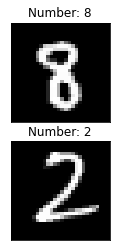

In [ ]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
print(images.shape)

fig = plt.figure()
for i in range(2):
  plt.subplot(2,1,i+1)
  plt.imshow(images[i].numpy().squeeze(), cmap='gray', interpolation='none')
  plt.title("Number: {}".format(labels[i]))
  plt.xticks([])
  plt.yticks([])

In [ ]:
class CNN_Net(nn.Module):
    def __init__(self):
        super(CNN_Net,self).__init__()
        self.layers1 = nn.Sequential(
        nn.Conv2d(1,12,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(12),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2,stride=2),
        #nn.AvgPool2d(kernel_size=2,stride=2),
        nn.Conv2d(12,24,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(24),
        nn.ReLU(inplace=True),
        #nn.AvgPool2d(kernel_size=2,stride=2)
        nn.MaxPool2d(kernel_size=2,stride=2)
      )
        self.layers2 = nn.Sequential(
          nn.Linear(in_features=24*7*7,out_features=30),
          nn.ReLU(),
          nn.Linear(in_features=30, out_features=10)
      )
    
    def forward(self,x):
        x=self.layers1(x)
        x=x.view(x.size(0),-1)
        x=self.layers2(x)
        return x


# Xavier-Glorot initialization of weights  
def glorot_weights(m):
    if isinstance(m,nn.Conv2d):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m,nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)

In [ ]:
model = CNN_Net()
model.apply(glorot_weights)
loss_func = nn.CrossEntropyLoss()

optimizer = optim.SGD(momentum=0.9,lr=0.05,params=model.parameters())

lr_scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer , step_size=10, gamma=0.1)

In [ ]:
print("Training the CNN Model :")
number_of_epochs = 50
#train_loss = list()
best_epoch = None
batch_accuracy =[]


batch_validation_accuracy = []
previous_loss = 100
patience_factor = 3

avg_training_loss = []
avg_training_accuracy = []

avg_validation_loss = []
avg_validation_accuracy = []
count = 0
print("Generating a list of Training and Validation accuracies with their losses :")
for epoch in range(number_of_epochs):
    training_loss = 0
    validation_loss = 0
    model.train()
    
    for i, (x, y) in enumerate(training_loader):
        images = Variable(x)
        labels = Variable(y)
        
        optimizer.zero_grad()
        
        output = model(images)
        
        loss = loss_func(output, labels)
        
        training_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        training_prediction = (torch.max(output.data, dim=1)[1] == labels.data)
        
        batch_accuracy.append(training_prediction.float().mean().item())
    avg_training_accuracy.append(np.mean(batch_accuracy))
    avg_training_loss.append(training_loss/(i+1))
    
    model.eval()
    
    for i, (x, y) in enumerate(validation_loader):
        images2 = Variable(x)
        labels2 = Variable(y)
        
        output2 = model(images2)
        
        loss2 = loss_func(output2, labels2)
        
        validation_loss += loss2.item()
        
        validation_prediction = (torch.max(output2.data, dim=1)[1] == labels2.data)
        
        batch_validation_accuracy.append(validation_prediction.float().mean().item())
    
    avg_validation_accuracy.append(np.mean(batch_validation_accuracy))

        
        
        
    current_validation_loss = validation_loss/(i+1)
    avg_validation_loss.append(current_validation_loss)
    
    
    
    if current_validation_loss < previous_loss:
        count=0
        previous_loss = current_validation_loss
        best_epoch = epoch
        torch.save(model.state_dict(), "model.dth")
        
    else:
        count+=1
        if count==1:
            best_epoch = epoch
        if count>=patience_factor:
            print("Losses for validation data increase from epoch :",best_epoch)
            print("Early Stopping takes place at epoch :",epoch)
            break
    lr_scheduler.step()
  
    print("\nEpoch is :",epoch+1)
    print("\nTraining Accuracy :",avg_training_accuracy)
    print("\nTraining Loss :",avg_training_loss)
    
    print("\nValidation Accuracy :",avg_validation_accuracy)
    print("\nValidation Loss :",avg_validation_loss)
    
print("\nThe average training accuracy is :",np.mean(avg_training_accuracy))
print("\nThe average training loss is :",np.mean(avg_training_loss))


print("\nThe average validation accuracy is :",np.mean(avg_validation_accuracy))
print("\nThe average validation loss is :",np.mean(avg_validation_loss))

Training the CNN Model :
Generating a list of Training and Validation accuracies with their losses :

Epoch is : 1

Training Accuracy : [0.94921875]

Training Loss : [0.16854625335968387]

Validation Accuracy : [0.9768949468085106]

Validation Loss : [0.07892546265855421]

Epoch is : 2

Training Accuracy : [0.94921875, 0.9630294727488151]

Training Loss : [0.16854625335968387, 0.07922598051939819]

Validation Accuracy : [0.9768949468085106, 0.9759807180851063]

Validation Loss : [0.07892546265855421, 0.07889632528159826]

Epoch is : 3

Training Accuracy : [0.94921875, 0.9630294727488151, 0.9699039790679305]

Training Loss : [0.16854625335968387, 0.07922598051939819, 0.05598607033904106]

Validation Accuracy : [0.9768949468085106, 0.9759807180851063, 0.9787234042553191]

Validation Loss : [0.07892546265855421, 0.07889632528159826, 0.05282753636748431]

Epoch is : 4

Training Accuracy : [0.94921875, 0.9630294727488151, 0.9699039790679305, 0.9733504887440758]

Training Loss : [0.168546253

The curves for losses of training data and validation data are :


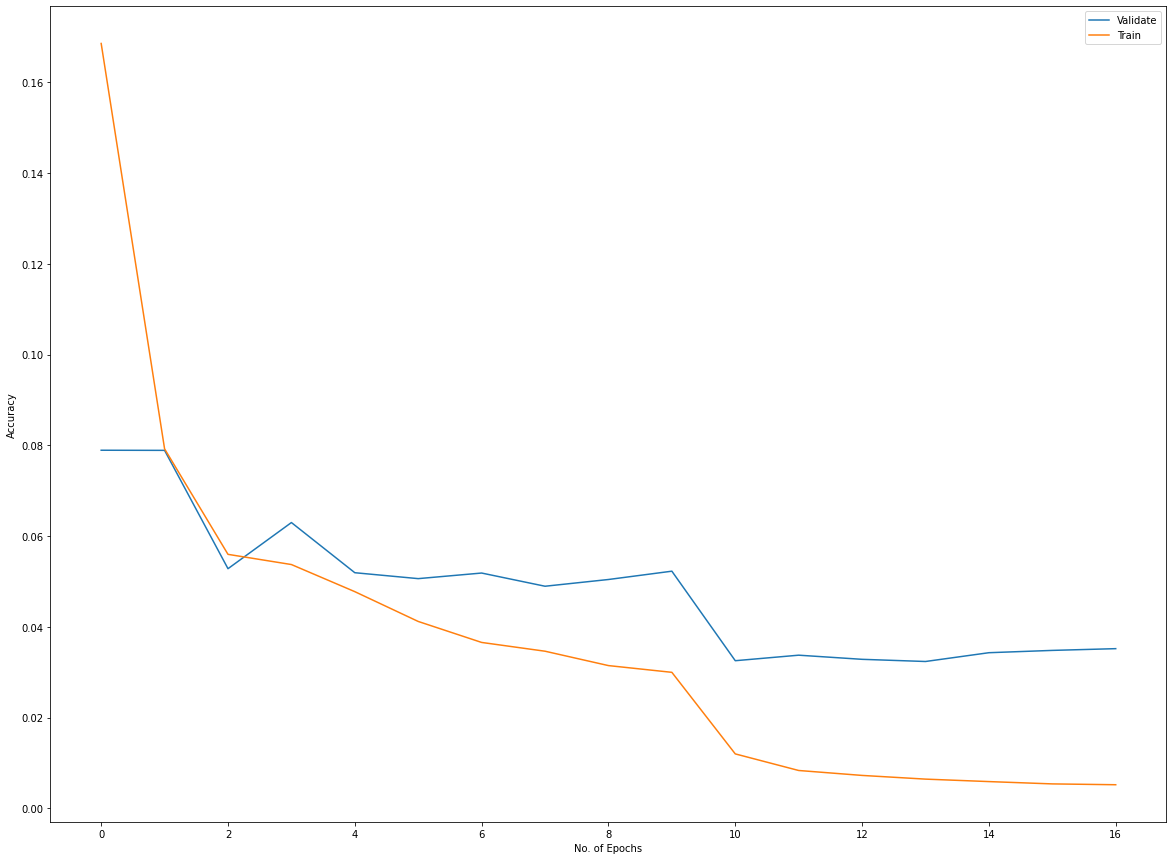

In [ ]:
print("The curves for losses of training data and validation data are :")
plt.figure(figsize=(20,15))
plt.plot(avg_validation_loss,label="Validate")
plt.plot(avg_training_loss,label="Train")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In this plot for losses, we see that the losses for training and validation data decrease gradually as we train the model and here we stop when the validation loss start increasing by a patience factor of 3. In this case, we get stop our training at epoch 16 and get our best model before the losses for validation start increasing continously.

The curves for accuracy of training data and validation data are :


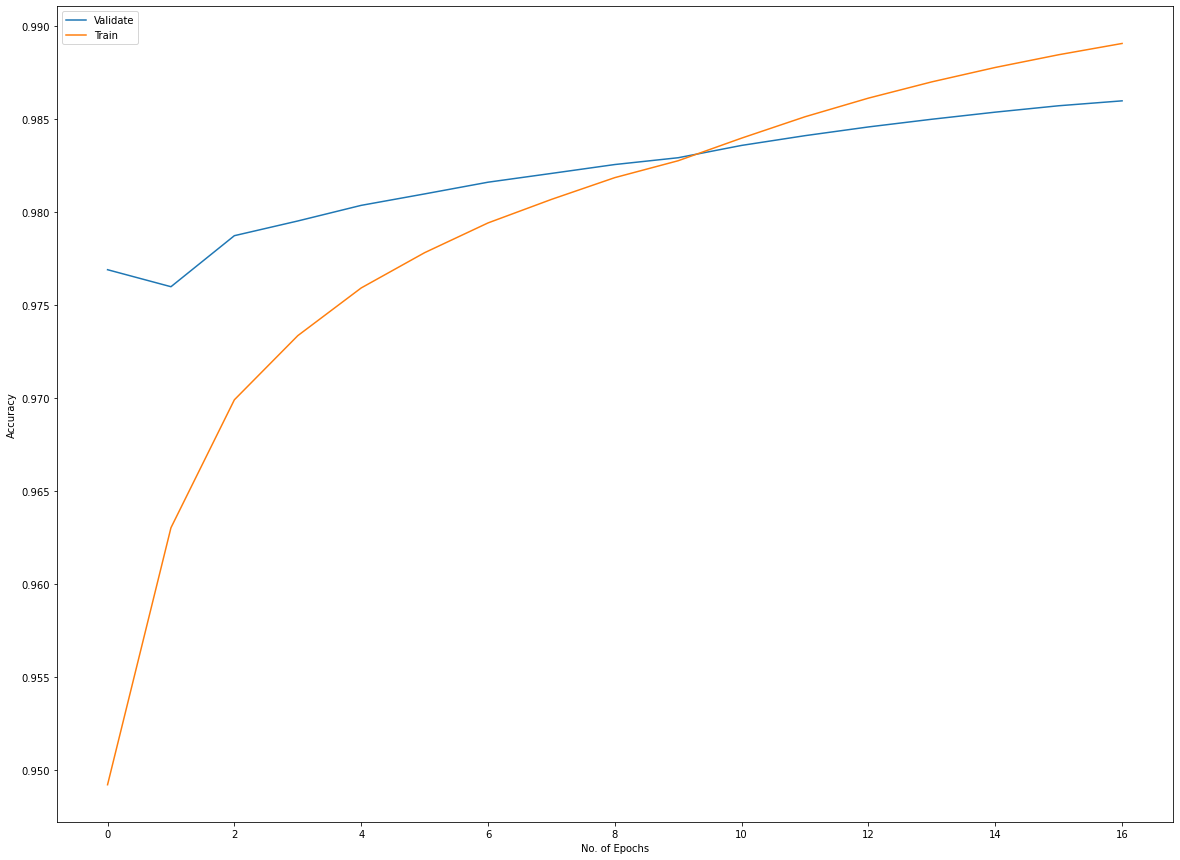

In [ ]:
print("The curves for accuracy of training data and validation data are :")
plt.figure(figsize=(20,15))
plt.plot(avg_validation_accuracy,label="Validate")
plt.plot(avg_training_accuracy,label="Train")
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In the above plot for accuracy, we see that accuracies for both the training data and validation data increase gradually as the number of epochs increase. The validation accuracy dips after 1st eopch but increases thereafter. When the training is stopped, we see that accuracies for training and validation set have crossed 98%

In [ ]:
print("Testing CNN Model:")
model.eval()
test_accuracy = 0
batch_test_accuracy = []
#avg_testing_accuracy = []
test_confusion_matrix = torch.zeros(10,  10)
for i , (x,y) in enumerate(test_loader):
    images3 = Variable(x)
    labels3 = Variable(y)
    
    output3 = model(images3)
    _, preds = torch.max(output3, 1)
    for t, p in zip(labels3.view(-1), preds.view(-1)):
                test_confusion_matrix[t.long(), p.long()] += 1
    #predictions = torch.cat((predictions,output3),dim=0)
    test_prediction = (torch.max(output3.data, dim=1)[1] == labels3.data)
        
    batch_test_accuracy.append(test_prediction.float().mean().item())
    
avg_test_accuracy = np.mean(batch_test_accuracy)

#print(batch_test_accuracy)
print("\nThe accuracy after testing the CNN model is :",avg_test_accuracy)
print("\nThe confusion matrix for test dataset is :")

class_names = ["0","1","2","3","4","5","6","7","8","9"]
test_confusion_matrix = pd.DataFrame(data=test_confusion_matrix,index=class_names,columns=class_names).astype(int)
print(test_confusion_matrix)

Testing CNN Model:

The accuracy after testing the CNN model is : 0.9895167731629393

The confusion matrix for test dataset is :
     0     1     2     3    4    5    6     7    8    9
0  977     0     0     0    0    0    1     1    1    0
1    0  1130     1     1    0    0    1     1    1    0
2    2     0  1020     3    0    0    1     5    1    0
3    0     0     0  1003    0    5    0     1    1    0
4    0     0     0     0  973    0    0     1    3    5
5    2     0     0     2    1  884    1     0    1    1
6    3     1     0     0    0    4  947     0    3    0
7    0     5     7     0    0    0    0  1013    0    3
8    4     0     2     0    0    1    0     0  965    2
9    1     2     1     1    3    5    0     8    5  983


In this file, we implemented Batch Normalization in our CNN architecture. Basically we added batch normalization after every convolution layer in our model. This technique is used to make the model training process more stable and faster. Here the mean and vaiance are internally computed. For this model, we keep rest of the architecture same i.e. weights initialization and learning rate. Using early stopping, we prevent overfitting our model and using the saved best model we run it for the testing dataset.
Using our model, we get a test accuracy of 98.95 i.e. almost 99% which is extremely accurate. From the above learning curves for loss and accuracy, we see that the graph fits reasonably well.

### References Used:
1. https://towardsdatascience.com/batch-normalization-in-3-levels-of-understanding-14c2da90a338